In [1]:
import pydicom
import glob, pylab
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")


import os
print(os.listdir("input"))

['.~lock.stage_1_sample_submission.csv#', 'stage_1_detailed_class_info.csv', 'stage_1_sample_submission.csv', 'stage_1_test_images', 'stage_1_train_images', 'stage_1_train_labels.csv']


In [2]:
# number of images in datasets
print(len(os.listdir("input/stage_1_test_images")), 'imgs in a test set')
print(len(os.listdir("input/stage_1_train_images")), 'imgs in a train set')

1000 imgs in a test set
25684 imgs in a train set


In [3]:
train_labels = pd.read_csv('input/stage_1_train_labels.csv', index_col='patientId')
train_labels.head()

,x,y,width,height,Target
patientId,,,,,
0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


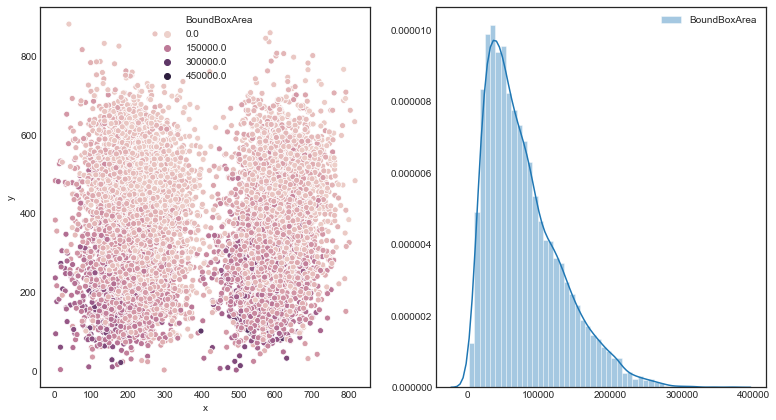

In [4]:
train_labels['BoundBoxArea'] = train_labels.width*train_labels.height
train_labels.BoundBoxArea.fillna(0, inplace=True)
boxes = train_labels[train_labels.BoundBoxArea > 0]

fig, axs = plt.subplots(1, 2, figsize=(13, 7))
sns.scatterplot(x='x', y='y', hue='BoundBoxArea', data=boxes, ax=axs[0])
sns.distplot(boxes.BoundBoxArea.values, ax=axs[1], label='BoundBoxArea')
plt.legend()
plt.show()

In [5]:
train_labels.head()

,x,y,width,height,Target,BoundBoxArea
patientId,,,,,,
0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,0.0
00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,0.0
00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,0.0
003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,0.0
00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,80727.0


In [6]:
#https://www.kaggle.com/peterchang77/exploratory-data-analysis

def parse_data(df):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...

      }

    """
    # --- Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': 'input/stage_1_train_images/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

def draw(data):
    """
    Method to draw single patient with bounding box(es) if present 

    """
    # --- Open DICOM file
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)

    pylab.imshow(im, cmap=pylab.cm.gist_gray)
    pylab.axis('off')

def overlay_box(im, box, rgb, stroke=1):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

In [7]:
df = pd.read_csv('input/stage_1_train_labels.csv')
parsed = parse_data(df)

In [8]:
parsed['0004cfab-14fd-4e49-80ba-63a80b6bddd6']

{'boxes': [],
 'dicom': 'input/stage_1_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm',
 'label': 0}

In [9]:
data = parsed[train_labels.index.unique()[7]]
d = pydicom.read_file(data['dicom'])
im = d.pixel_array
data

{'boxes': [[577.0, 323.0, 104.0, 160.0], [575.0, 695.0, 137.0, 162.0]],
 'dicom': 'input/stage_1_train_images/00704310-78a8-4b38-8475-49f4573b2dbb.dcm',
 'label': 1}

In [10]:
data

{'boxes': [[577.0, 323.0, 104.0, 160.0], [575.0, 695.0, 137.0, 162.0]],
 'dicom': 'input/stage_1_train_images/00704310-78a8-4b38-8475-49f4573b2dbb.dcm',
 'label': 1}

Data loaded. 

# Things I can try: 

 - Try a simple classifier on target values. Make it flow from directory. 
 - Yolo3 on bounding boxes
 - Potentially use Unet model to segment the lungs and than run Yolo. 
        (https://colab.research.google.com/github/mdai/ml-lessons/blob/master/lesson2-lung-xrays-segmentation.ipynb)
 - ??

In [11]:
from keras.applications import vgg16
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications import inception_resnet_v2,densenet
from keras.applications import resnet50
from keras.applications import vgg19
from keras.preprocessing.image import ImageDataGenerator
import cv2
import PIL
from sklearn.metrics import log_loss, accuracy_score
from sklearn.linear_model import LogisticRegression

c:\users\popeye\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [12]:
INPUT_SIZE1 = 224
INPUT_SIZE2 = 299
N = len(train_labels.index.unique())

In [14]:
imgs1 = np.zeros((N,INPUT_SIZE1,INPUT_SIZE1,3))
#imgs2 = np.zeros((N,INPUT_SIZE2,INPUT_SIZE2,3))

In [16]:
for i in range(N):
    data = parsed[train_labels.index.unique()[i]]
    d = pydicom.read_file(data['dicom']).pixel_array.astype('uint8')
    im1 =  cv2.resize(d,(INPUT_SIZE1, INPUT_SIZE1))
    imgs1[i,:,:,0] = im1
    imgs1[i,:,:,1] = im1
    imgs1[i,:,:,2] = im1
    #im2 =  cv2.resize(d,(INPUT_SIZE2, INPUT_SIZE2))
    #imgs2[i,:,:,0] = im2
    #imgs2[i,:,:,1] = im2
    #imgs2[i,:,:,2] = im2    
    if i%5000 ==0:
        print(i)    

0
5000
10000
15000
20000
25000


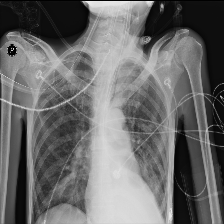

In [18]:
im = PIL.Image.fromarray(imgs1[N-1].astype('uint8'),'RGB')
im

In [19]:
y = np.zeros((N,))
for i in range(N):
    data = parsed[train_labels.index.unique()[i]]
    y[i] = data['label']
    if i%5000 ==0:
        print(i)
    

0
5000
10000
15000
20000
25000


In [20]:
n= (0.8*N)
n = int(n)
#Xtr = imgs[0:n]
#Xv = imgs[n:]
ytr = y[:n]
yv = y[n:]

In [21]:
models = {
    "DenseNet": {
        "model": densenet.DenseNet201,
        "preprocessor": densenet.preprocess_input,
        "input_shape": (224,224,3),
        "seed": 5512,
        "pooling": "avg",
        "color": 3,
        "val_logloss": 0,
        "val_acc":0,
        "logreg":None
    },          
    "Xception": {
        "model": xception.Xception,
        "preprocessor": xception.preprocess_input,
        "input_shape": (299,299,3),
        "seed": 5512,
        "pooling": "avg",
        "color": 3,
        "val_logloss": 0,
        "val_acc":0,
        "logreg":None
    }, 
    "Inception": {
        "model": inception_v3.InceptionV3,
        "preprocessor": inception_v3.preprocess_input,
        "input_shape": (299,299,3),
        "seed": 5512,
        "pooling": "avg",
        "color": 3,
        "val_logloss": 0,
        "val_acc":0,
        "logreg":None
    },
    "Inseption_ResNet_V2": {
        "model": inception_resnet_v2.InceptionResNetV2,
        "preprocessor": inception_resnet_v2.preprocess_input,
        "input_shape": (299,299,3),
        "seed": 5512,
        "pooling": "avg",
        "color": 3,
        "val_logloss": 0,
        "val_acc":0,
        "logreg":None
    },               
    "DenseNet169": {
        "model": densenet.DenseNet169,
        "preprocessor": densenet.preprocess_input,
        "input_shape": (224,224,3),
        "seed": 5512,
        "pooling": "avg",
        "color": 3,
        "val_logloss": 0,
        "val_acc":0,
        "logreg":None
    }, 
    "DenseNet121": {
        "model": densenet.DenseNet121,
        "preprocessor": densenet.preprocess_input,
        "input_shape": (224,224,3),
        "seed": 5512,
        "pooling": "avg",
        "color": 3,
        "val_logloss": 0,
        "val_acc":0,
        "logreg":None
    },                 
    "ResNet50": {
        "model": resnet50.ResNet50,
        "preprocessor": resnet50.preprocess_input,
        "input_shape": (224,224,3),
        "seed": 5512,
        "pooling": "avg",
        "color": 3,
        "val_logloss": 0,
        "val_acc":0,
        "logreg":None
    },
    "VGG19": {
        "model": vgg19.VGG19,
        "preprocessor": vgg19.preprocess_input,
        "input_shape": (224,224,3),
        "seed": 5512,
        "pooling": "avg",
        "color": 3,
        "val_logloss": 0,
        "val_acc":0,
        "logreg":None
    },                
    "VGG16": {
        "model": vgg16.VGG16,
        "preprocessor": vgg16.preprocess_input,
        "input_shape": (224,224,3),
        "seed": 5512,
        "pooling": "avg",
        "color": 3,
        "val_logloss": 0,
        "val_acc":0,
        "logreg":None
    }           
}

In [37]:
def generate_features(model_info, imgs,ytr,generator):
    print("generating features...", model_info["model"]) 
    
    validation_datagen = ImageDataGenerator(preprocessing_function = model ["preprocessor"])
    train_datagen = ImageDataGenerator(preprocessing_function = model ["preprocessor"])
    
    batch_size = 64    
    bottleneck_model = model_info["model"](weights='imagenet', 
                                 include_top=False, input_shape=model_info["input_shape"], 
                                 pooling=model_info["pooling"])

    generator1 = train_datagen.flow(imgs, ytr, shuffle=False, batch_size=batch_size, seed=model_info["seed"])    
    bottleneck_features = bottleneck_model.predict_generator(generator1,steps = len(generator1),verbose=1)
    
    labels = ytr        
    validation_features = bottleneck_model.predict_generator(generator)
    
    
    return bottleneck_features, validation_features, labels

In [38]:
train_folder = os.path.join('logs','logreg_classifiers')
if not os.path.exists(train_folder):
    os.mkdir(train_folder)
SEED = 445
for model_name, model in models.items():
    print("Predicting : {}".format(model_name))
    filename = os.path.join(train_folder,model_name + '_features.npy')
    validfilename = os.path.join(train_folder,model_name + '_validfeatures.npy')
    labelsfilename = os.path.join(train_folder,model_name + '_labels.npy')
    if not os.path.exists(filename):
        validation_datagen = ImageDataGenerator(preprocessing_function = model ["preprocessor"])
        if model["input_shape"][0]==INPUT_SIZE1:
            generator = validation_datagen.flow(imgs1[n:],   yv, shuffle=False, batch_size=64, seed=SEED)
            features, validation_features, labels = generate_features(model, imgs1[:n],ytr,generator)          

            np.save(filename, features)
            np.save(validfilename, validation_features)
            np.save(labelsfilename, labels)

Predicting : Inception
Predicting : DenseNet121
generating features... <function DenseNet121 at 0x000001E90BFA2950>
322/322 [==============================] - 162s 502ms/step
Predicting : Inseption_ResNet_V2
Predicting : ResNet50
generating features... <function ResNet50 at 0x000001E90BF98AE8>
322/322 [==============================] - 140s 434ms/step
Predicting : VGG16
generating features... <function VGG16 at 0x000001E90BF98378>
322/322 [==============================] - 135s 419ms/step
Predicting : DenseNet169
generating features... <function DenseNet169 at 0x000001E90BFA29D8>
322/322 [==============================] - 199s 618ms/step
Predicting : Xception
Predicting : VGG19
generating features... <function VGG19 at 0x000001E90BF98840>
322/322 [==============================] - 159s 493ms/step
Predicting : DenseNet
generating features... <function DenseNet201 at 0x000001E90BFA2A60>
322/322 [==============================] - 263s 816ms/step


In [42]:
for model_name, model in models.items():
    print("Analyzing : {}".format(model_name))
    
    filename = os.path.join(train_folder,model_name + '_features.npy')
    validfilename = os.path.join(train_folder,model_name + '_validfeatures.npy')
    labelsfilename = os.path.join(train_folder,model_name + '_labels.npy')


    if os.path.exists(filename):
        features = np.load(filename)
        validation_features = np.load(validfilename)
        labels = np.load(labelsfilename)        
        aug = 25
        train_features = features
        train_labels = labels        
        print(train_features.shape,train_labels.shape,validation_features.shape)
        logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
        logreg.fit(train_features,train_labels)
        valid_probs = logreg.predict_proba(validation_features)
        valid_preds = logreg.predict(validation_features)       
        print('Validation LogLoss {}'.format(log_loss(yv, valid_probs)))
        print('Validation Accuracy {}'.format(accuracy_score(yv, valid_preds)))
        print(logreg.score(train_features,train_labels))
        models[model_name]["val_logloss"]=log_loss(yv, valid_probs)
        models[model_name]["val_acc"]=accuracy_score(yv, valid_preds)
        models[model_name]["logreg"]=logreg

Analyzing : Inception
Analyzing : DenseNet121
(20547, 1024) (20547,) (5137, 1024)
Validation LogLoss 0.4086666453092189
Validation Accuracy 0.8504963986762702
0.8241592446585876
Analyzing : Inseption_ResNet_V2
Analyzing : ResNet50
(20547, 2048) (20547,) (5137, 2048)
Validation LogLoss 0.39451808267738164
Validation Accuracy 0.8516643955616119
0.8440648269820412
Analyzing : VGG16
(20547, 512) (20547,) (5137, 512)
Validation LogLoss 0.41064656599810506
Validation Accuracy 0.8483550710531439
0.8245972648075145
Analyzing : DenseNet169
(20547, 1664) (20547,) (5137, 1664)
Validation LogLoss 0.3987680722347649
Validation Accuracy 0.8499124002335994
0.8352070861926315
Analyzing : Xception
Analyzing : VGG19
(20547, 512) (20547,) (5137, 512)
Validation LogLoss 0.4155499042979449
Validation Accuracy 0.8430990850691065
0.8215311237650266
Analyzing : DenseNet
(20547, 1920) (20547,) (5137, 1920)
Validation LogLoss 0.4024331827665928
Validation Accuracy 0.8497177340860425
0.8369104978829026


In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function = none)
generator = train_datagen.flow(imgs[0:n],   ytr, shuffle=False, batch_size=8)


In [ ]:
model = vgg16.VGG16(weights='imagenet',include_top=False, input_shape=(INPUT_SIZE,INPUT_SIZE,3), pooling='avg')

In [ ]:
#features = model.predict_generator(generator,verbose=1)
#np.save('vggfeatures.npy',features)
features = np.load('vggfeatures.npy')
print(features.shape)

In [ ]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logreg.fit(features,ytr)
logreg.score(features,ytr)

In [ ]:
val_datagen = ImageDataGenerator(preprocessing_function = vgg16.preprocess_input)
val_generator = val_datagen.flow(imgs[n:],  yv, shuffle=False, batch_size=8)
val_features = model.predict_generator(val_generator,verbose=1)
np.save('vggfeatures_val.npy',val_features)
valid_preds = logreg.predict(val_features)  
print('Validation Accuracy {}'.format(accuracy_score(yv, valid_preds)))